<a href="https://colab.research.google.com/github/BobbyRex/IBM-Capstone-Battle-of-the-neighborhoods/blob/Final/Best_Neighborhood_for_French_Restaurant_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using Foursquare data and neighbourhood profiles to find the best spot in Toronto to start up a French restaurant

##*Background* 
According to the last census, more than 50,000 Torontonians identified themselves as francophones. Every year roughly 1,000 French-speaking immigrants settle in Toronto, with the occasional spike – after the 2011 earthquake in Haiti, for example [1](https://www.theglobeandmail.com/news/toronto/a-cultural-shift-for-toronto-as-invisible-francophones-settle-in/article26232519/). There is, however, no defined francophone neighborhood in Toronto. For those who wish to start up a French restaurant, this project aims to select the best neighborhood in Toronto for this matter. Variables taken into account includes e.g. french speaking rate, average income, crime rate, migration rate, restaurant frequency.

##*Material and methods*
Datasets on  [Toronto neighborhood profiles](https://open.toronto.ca/dataset/neighbourhood-profiles/) and crime statistics from the [Toronto Police Service](https://data.torontopolice.on.ca/pages/asr-open-data) will be merged. Restaurants, grouped by neighborhood, will be obtained through requests from the Foursquare API. A score will be calculated based on selected variables predicted to influence the decision. Top scoring neighborhoods will be suberimposed over a map of Toronto using Folium. The relative contribution of each selected variable to the final score will be calculated and plotted. Scores will subsequently be compared between groups generated by *k*-means clustering. The provided material will serve as basis for further exploration of the neighborhoods by the customer wishing to start up a French restaurant in Toronto.

####First, lets import the required libraries:

In [2]:
%matplotlib inline 
!pip install pyforest
import pyforest
from geopy.geocoders import Nominatim
import io
import json
from pandas.io.json import json_normalize
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
print('Libraries imported.')


  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13716 sha256=d1d0a91e4626a01049c17c41398e01a5ebe2713f18cfa767d3a5ea35e78573df
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest
Libraries imported.


####Variables needed later to access Geopy and Foursquare API

In [3]:
#Foursquare
CLIENT_ID = 'BJYOEN12FKXPVNXL53N3E0IYSTUKWRXIN0KWV5L5HUQOTV2C' 
CLIENT_SECRET = 'AW2MRYSVU3O2FBZRMUSZ3LBMKZK5K0REYASL5BDSF15DYBGY' 
VERSION = '20180604'
LIMIT = 300 

#Getting coordinates of Toronto
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address, timeout=15)
latitude = location.latitude
longitude = location.longitude

####Let's define the functions needed later on

In [4]:
def get_toronto_data():
#To import downloaded dataset on Toronto census from https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv 
  from google.colab import files
  uploaded = files.upload()
  demographics = pd.read_csv(io.BytesIO(uploaded['neighbourhood-profiles-2016-csv.csv']), thousands=',')
  return demographics

def get_crime_rates():
# to fetch crime data from the Toronto Police and calculate a total crime rate per neighborhood  
  !wget -q -O 'crimes.json' "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Neighbourhood_MCI/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
  
  with open('crimes.json') as json_data:
    crime_data = json.load(json_data)
  
  features = crime_data['features']
  
  column_names = ['Neighborhood', 
                  "Assault rate", 
                  "Autotheft rate", 
                  "Breakandenter rate", 
                  "Homicide rate", 
                  "Robbery rate", 
                  "Theftover rate"
                  ] 
  crimes = pd.DataFrame(columns=column_names)

  for data in features:
    neigh = data['attributes']['Neighbourhood'] 
    assault = data['attributes']['Assault_Rate_2019']
    auto = data['attributes']['AutoTheft_Rate_2019']
    bae = data['attributes']['BreakandEnter_Rate_2019']
    homicide = data['attributes']['Homicide_Rate_2019']
    robbery = data['attributes']['Robbery_Rate_2019']
    theft = data['attributes']['TheftOver_Rate_2019']
    crimes = crimes.append({
                            'Neighborhood': neigh,
                            'Assault rate': assault,
                            'Autotheft rate': auto,
                            'Breakandenter rate': bae,
                            'Homicide rate': homicide,
                            'Robbery rate': robbery,
                            'Theftover rate': theft
                            }, ignore_index=True)
  return(crimes)

def get_mean_crime_rate():
  #This function normalizes crime rates and adds the mean of all crime types into a new column
  crime_array = crimes[[
                        "Assault rate", 
                        "Autotheft rate", 
                        "Breakandenter rate",	
                        "Homicide rate", 
                        "Robbery rate", 
                        "Theftover rate"
                        ]].values.astype(float)
  crime_array = preprocessing.StandardScaler().fit(crime_array).transform(crime_array.astype(float))
  crimes_norm = pd.DataFrame(crime_array, columns = [
                                                     "Assault rate", 
                                                     "Autotheft rate", 
                                                     "Breakandenter rate",	
                                                     "Homicide rate", 
                                                     "Robbery rate", 
                                                     "Theftover rate",
                                                    ]
                             )
  crimes_norm['Normalized crime rate'] = crimes_norm.mean(axis=1)
  crimes_norm.insert(0, "Neighborhood", crimes["Neighborhood"])
  return(crimes_norm)
  


def get_nearby_venues(names, latitudes, longitudes, radius=1000):
#fix to only fetch restaurants?   
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'id', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


def calculate_WSS(points, kmax):
#Elbow method: function returns WSS score for k values from 1 to kmax
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

###1. Construct a demographics dataframe
####I will use the neighbourhood profiles 2016 dataset from the [Toronto open data portal](https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv):

In [ ]:
to_data = get_toronto_data() 
to_data.head()

Saving neighbourhood-profiles-2016-csv.csv to neighbourhood-profiles-2016-csv (2).csv


,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

####First, some processing is required as well as transposing the dataset

In [ ]:
to_data.drop(['_id', 'Category', 'Topic', 'Data Source'], axis=1, inplace=True)
to_data = to_data.transpose()
to_data.head()

0                     1     \
Characteristic                Neighbourhood Number  TSNS2020 Designation   
City of Toronto                                NaN                   NaN   
Agincourt North                                129        No Designation   
Agincourt South-Malvern West                   128        No Designation   
Alderwood                                       20        No Designation   

                                          2                 3     \
Characteristic                Population, 2016  Population, 2011   
City of Toronto                      2,731,571         2,615,060   
Agincourt North                         29,113            30,279   
Agincourt South-Malvern West            23,757            21,988   
Alderwood                               12,054            11,904   

                                                     4     \
Characteristic                Population Change 2011-2016   
City of Toronto                                     4.50%   
Agincourt North                                    -3.90%   
Agincourt South-Malvern West                        8.00%   
Alderwood                                           1.30%   

                                                 5     \
Characteristic                Total private dwellings   
City of Toronto                             1,179,057   
Agincourt North                                 9,371   
Agincourt South-Malvern West                    8,535   
Alderwood                                       4,732   

                                                                       6     \
Characteristic                Private dwellings occupied by usual residents   
City of Toronto                                                   1,112,929   
Agincourt North                                                       9,120   
Agincourt South-Malvern West                                          8,136   
Alderwood                                                             4,616   

                                                                 7     \
Characteristic                Population density per square kilometre   
City of Toronto                                                 4,334   
Agincourt North                                                 3,929   
Agincourt South-Malvern West                                    3,034   
Alderwood                                                       2,435   

                                                        8     \
Characteristic                Land area in square kilometres   
City of Toronto                                        630.2   
Agincourt North                                         7.41   
Agincourt South-Malvern West                            7.83   
Alderwood                                               4.95   

                                               9                    10    \
Characteristic                Children (0-14 years)  Youth (15-24 years)   
City of Toronto                             398,135              340,270   
Agincourt North                               3,840                3,705   
Agincourt South-Malvern West                  3,075                3,360   
Alderwood                                     1,760                1,235   

                                                   11    \
Characteristic                Working Age (25-54 years)   
City of Toronto                               1,229,555   
Agincourt North                                  11,305   
Agincourt South-Malvern West                      9,965   
Alderwood                                         5,220   

                                                      12    \
Characteristic                Pre-retirement (55-64 years)   
City of Toronto                                    336,670   
Agincourt North                                      4,230   
Agincourt South-Malvern West                         3,265   
Alderwood                                        

####There is a lot of interesting info here, I will pick a few variables related to population, income and French speakers as these are likely to contribute to the success of opening a French restaurant

In [ ]:
#Interesting variables 
to_selected = to_data[[4, 7, 129, 130, 2272]]
to_selected.head(3)

,2,4,7,129,130,2272
Characteristic,"Population, 2016",Population Change 2011-2016,Population density per square kilometre,French only,English and French,Total income: Average amount ($)
City of Toronto,"2,731,571",4.50%,"4,334","2,725","245,695","52,268"
Agincourt North,"29,113",-3.90%,"3,929",15,"1,235","30,414"


####The first row should be the column names:

In [ ]:
to_selected.reset_index(inplace=True)
to_selected.columns = to_selected.iloc[0]

#slicing off copy of column titles and "City of Toronto" rows since these are not needed"
to_selected = to_selected[2:]
to_selected.reset_index(inplace=True, drop=True)

print(to_selected.dtypes)
to_selected.head(3)

0
Characteristic                             object
Population, 2016                           object
Population Change 2011-2016                object
Population density per square kilometre    object
  French only                              object
  English and French                       object
Total income: Average amount ($)           object
dtype: object


,Characteristic,"Population, 2016",Population Change 2011-2016,Population density per square kilometre,French only,English and French,Total income: Average amount ($)
0,Agincourt North,"29,113",-3.90%,"3,929",15,"1,235","30,414"
1,Agincourt South-Malvern West,"23,757",8.00%,"3,034",5,"1,060","31,825"
2,Alderwood,"12,054",1.30%,"2,435",0,890,"47,709"


####Changing column dtypes to numeric

In [ ]:
to_selected['Population, 2016'] = to_selected['Population, 2016'].str.replace(',', '').astype('int64')
to_selected['Population Change 2011-2016'] = to_selected['Population Change 2011-2016'].str.replace('%', '').astype(float)
to_selected['Population density per square kilometre'] = to_selected['Population density per square kilometre'].str.replace(',', '').astype('int64')
to_selected['  French only'] = to_selected['  French only'].str.replace(',', '').astype('int64')                                                      #the indentation of the column name is from the .csv and will be fixed later
to_selected['  English and French'] = to_selected['  English and French'].str.replace(',', '').astype('int64')
to_selected['Total income: Average amount ($)'] = to_selected['Total income: Average amount ($)'].str.replace(',', '').astype('int64')

to_selected.dtypes

0
Characteristic                              object
Population, 2016                             int64
Population Change 2011-2016                float64
Population density per square kilometre      int64
  French only                                int64
  English and French                         int64
Total income: Average amount ($)             int64
dtype: object

####Let's add a column with the percentage of French-speakers in the neighborhood

In [ ]:
to_selected['French speaking (%)'] = ((to_selected['  French only']+to_selected['  English and French'])/to_selected['Population, 2016'])*100
to_selected.head()

,Characteristic,"Population, 2016",Population Change 2011-2016,Population density per square kilometre,French only,English and French,Total income: Average amount ($),French speaking (%)
0,Agincourt North,29113,-3.9,3929,15,1235,30414,4.293615
1,Agincourt South-Malvern West,23757,8.0,3034,5,1060,31825,4.482889
2,Alderwood,12054,1.3,2435,0,890,47709,7.383441
3,Annex,30526,4.6,10863,10,6015,112766,19.737273
4,Banbury-Don Mills,27695,2.9,2775,20,2895,67757,10.525366


####Some further processing of the data

In [ ]:
#removing raw french speaking columns, changing column orders and names
to_selected = to_selected[['Characteristic', 
                        'Population Change 2011-2016',
                        'Population density per square kilometre',
                        'Total income: Average amount ($)',
                        'French speaking (%)']].rename(columns = {'Characteristic': 'Neighborhood', 
                                                                'Population Change 2011-2016': 'Migration (%)',
                                                                'Population density per square kilometre': 'Population per sqkm', 
                                                                'Total income: Average amount ($)':'Average income ($}'
                                                                }
                                                       )                                                               
to_selected.head(2)

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%)
0,Agincourt North,-3.9,3929,30414,4.293615
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889


###2. Geocoding for adresses and coordinates
####Geopy's geolocator is used, first to get geocodes from neighborhoods:

In [ ]:
geolocator = Nominatim(user_agent='foursquare_agent')
to_selected['full_address'] = to_selected.Neighborhood + ', Toronto, ON'    #to tell Geopy that it should look in Toronto to rule out multiple findings
to_selected['gcode'] = to_selected.full_address.apply(geolocator.geocode)

####Did we get g.addresses for all neighborhoods?

In [ ]:
to_missing = to_selected[to_selected['gcode'].isna()]
print('Total number of neighborhoods: ', (len(to_selected)-1), '\nNeighborhoods with missing g.addresses: ', (len(to_missing)-1))

Total number of neighborhoods:  139 
Neighborhoods with missing g.addresses:  30


####Geopy could not find a g.address for 30 of our neighborhoods. That is a bit tedious to manually curate
Luckily, some googling revealed that others had had similar issues with this dataset and performed this curation before, so I borrowed parts of the code:

In [ ]:
#Adding lat/lon columns
to_missing.pop('full_address') 	
to_missing.pop('gcode') 	
to_missing[["Latitude","Longitude"]] = '',''
to_missing.reset_index(inplace=True, drop=True)

for row in to_missing.itertuples():
    if to_missing.iloc[row.Index, 0] == 'Agincourt South-Malvern West':
        to_missing.iloc[row.Index, 5] =  43.7925
        to_missing.iloc[row.Index, 6] =  -79.283889
    elif to_missing.iloc[row.Index, 0] == 'Bedford Park-Nortown':
        to_missing.iloc[row.Index, 5] =  43.73
        to_missing.iloc[row.Index, 6] =  -79.411
    elif to_missing.iloc[row.Index, 0] == 'Cabbagetown-South St. James Town':
        to_missing.iloc[row.Index, 5] =  43.620543
        to_missing.iloc[row.Index, 6] =  -79.47793
    elif to_missing.iloc[row.Index, 0] == 'Downsview-Roding-CFB':
        to_missing.iloc[row.Index, 5] =  43.732222
        to_missing.iloc[row.Index, 6] =  -79.493333
    elif to_missing.iloc[row.Index, 0] == 'Mimico (includes Humber Bay Shores)':
        to_missing.iloc[row.Index, 5] =  43.612778
        to_missing.iloc[row.Index, 6] =  -79.494167
    elif to_missing.iloc[row.Index, 0] == 'Beechborough-Greenbrook':
        to_missing.iloc[row.Index, 5] =  43.6943
        to_missing.iloc[row.Index, 6] =  -79.4748
    elif to_missing.iloc[row.Index, 0] == 'Birchcliffe-Cliffside':
        to_missing.iloc[row.Index, 5] =  43.7089
        to_missing.iloc[row.Index, 6] =  -79.2485
    elif to_missing.iloc[row.Index, 0] == 'Bridle Path-Sunnybrook-York Mills':
        to_missing.iloc[row.Index, 5] =  43.7359
        to_missing.iloc[row.Index, 6] =  -79.3719
    elif to_missing.iloc[row.Index, 0] == 'Brookhaven-Amesbury':
        to_missing.iloc[row.Index, 5] =  43.6969
        to_missing.iloc[row.Index, 6] =  -79.4938
    elif to_missing.iloc[row.Index, 0] == 'Clairlea-Birchmount':
        to_missing.iloc[row.Index, 5] =  43.7162
        to_missing.iloc[row.Index, 6] =  -79.2828
    elif to_missing.iloc[row.Index, 0] == 'Dovercourt-Wallace Emerson-Junction':
        to_missing.iloc[row.Index, 5] =  43.663
        to_missing.iloc[row.Index, 6] =  -79.441
    elif to_missing.iloc[row.Index, 0] == 'Eringate-Centennial-West Deane':
        to_missing.iloc[row.Index, 5] =  43.6599
        to_missing.iloc[row.Index, 6] =  -79.5833
    elif to_missing.iloc[row.Index, 0] == 'Greenwood-Coxwell':
        to_missing.iloc[row.Index, 5] =  43.6721
        to_missing.iloc[row.Index, 6] =  -79.3228
    elif to_missing.iloc[row.Index, 0] == 'Humbermede':
        to_missing.iloc[row.Index, 5] =  43.746297
        to_missing.iloc[row.Index, 6] =  -79.541186
    elif to_missing.iloc[row.Index, 0] == 'Islington-City Centre West':
        to_missing.iloc[row.Index, 5] =  43.6309
        to_missing.iloc[row.Index, 6] =  -79.5435
    elif to_missing.iloc[row.Index, 0] == 'Leaside-Bennington':
        to_missing.iloc[row.Index, 5] =  43.708
        to_missing.iloc[row.Index, 6] =  -79.368
    elif to_missing.iloc[row.Index, 0] == 'Mount Olive-Silverstone-Jamestown':
        to_missing.iloc[row.Index, 5] =  43.739722
        to_missing.iloc[row.Index, 6] =  -79.580278
    elif to_missing.iloc[row.Index, 0] == 'Parkwoods-Donalda':
        to_missing.iloc[row.Index, 5] =  43.7528
        to_missing.iloc[row.Index, 6] =  -79.3264
    elif to_missing.iloc[row.Index, 0] == 'Playter Estates-Danforth':
        to_missing.iloc[row.Index, 5] =  43.68
        to_missing.iloc[row.Index, 6] =  -79.349
    elif to_missing.iloc[row.Index, 0] == 'Princess-Rosethorn':
        to_missing.iloc[row.Index, 5] =  43.6700
        to_missing.iloc[row.Index, 6] =  -79.5477
    elif to_missing.iloc[row.Index, 0] == 'Rockcliffe-Smythe':
        to_missing.iloc[row.Index, 5] =  43.6769
        to_missing.iloc[row.Index, 6] =  -79.4894
    elif to_missing.iloc[row.Index, 0] == 'St.Andrew-Windfields':
        to_missing.iloc[row.Index, 5] =  43.7548
        to_missing.iloc[row.Index, 6] =  -79.3855
    elif to_missing.iloc[row.Index, 0] == "Tam O'Shanter-Sullivan":
        to_missing.iloc[row.Index, 5] =  43.7811
        to_missing.iloc[row.Index, 6] =  -79.2981
    elif to_missing.iloc[row.Index, 0] == 'Thistletown-Beaumond Heights':
        to_missing.iloc[row.Index, 5] =  43.737222
        to_missing.iloc[row.Index, 6] =  -79.565278
    elif to_missing.iloc[row.Index, 0] == 'Westminster-Branson':
        to_missing.iloc[row.Index, 5] =  43.7856
        to_missing.iloc[row.Index, 6] =  -79.4511
    elif to_missing.iloc[row.Index, 0] == 'Wexford/Maryvale':
        to_missing.iloc[row.Index, 5] =  43.7613
        to_missing.iloc[row.Index, 6] =  -79.3008
    elif to_missing.iloc[row.Index, 0] == 'Willowridge-Martingrove-Richview':
        to_missing.iloc[row.Index, 5] =  43.6762
        to_missing.iloc[row.Index, 6] =  -79.5705
    elif to_missing.iloc[row.Index, 0] == 'Bay Street Corridor':
        to_missing.iloc[row.Index, 5] =  43.657291
        to_missing.iloc[row.Index, 6] =  -79.384302 
    elif to_missing.iloc[row.Index, 0] == 'Bathurst Manor':
        to_missing.iloc[row.Index, 5] =  43.7628
        to_missing.iloc[row.Index, 6] =  -79.4569
    elif to_missing.iloc[row.Index, 0] == 'Bay Street Corridor':
        to_missing.iloc[row.Index, 5] =  43.7303
        to_missing.iloc[row.Index, 6] =  -79.384302
    elif to_missing.iloc[row.Index, 0] == 'Bedford':
        to_missing.iloc[row.Index, 5] =  43.7628
        to_missing.iloc[row.Index, 6] =  -79.4114
    elif to_missing.iloc[row.Index, 0] == 'Black Creek':
        to_missing.iloc[row.Index, 5] =  43.669444
        to_missing.iloc[row.Index, 6] =  -79.511389
    elif to_missing.iloc[row.Index, 0] == 'Briar Hill-Belgravia':
        to_missing.iloc[row.Index, 5] =  43.7037
        to_missing.iloc[row.Index, 6] =  -79.4524
    elif to_missing.iloc[row.Index, 0] == 'Forest Hill South':
        to_missing.iloc[row.Index, 5] =  43.6932
        to_missing.iloc[row.Index, 6] =  -79.4126
    elif to_missing.iloc[row.Index, 0] == 'Glenfield-Jane Heights':
        to_missing.iloc[row.Index, 5] =  43.757222
        to_missing.iloc[row.Index, 6] =  -79.517778
    elif to_missing.iloc[row.Index, 0] == 'Junction Area':
        to_missing.iloc[row.Index, 5] =  43.665556
        to_missing.iloc[row.Index, 6] =  -79.464444
    elif to_missing.iloc[row.Index, 0] == 'Kennedy Park':
        to_missing.iloc[row.Index, 5] =  43.716667
        to_missing.iloc[row.Index, 6] =  -79.259722
    elif to_missing.iloc[row.Index, 0] == 'Kingsway South':
        to_missing.iloc[row.Index, 5] =  43.6527
        to_missing.iloc[row.Index, 6] =  -79.5072
    elif to_missing.iloc[row.Index, 0] == 'Lambton Baby Point':
        to_missing.iloc[row.Index, 5] =  43.6575
        to_missing.iloc[row.Index, 6] =  -79.4925
    elif to_missing.iloc[row.Index, 0] == 'Malvern':
        to_missing.iloc[row.Index, 5] =  43.811667
        to_missing.iloc[row.Index, 6] =  -79.231111
    elif to_missing.iloc[row.Index, 0] == 'Markland Wood':
        to_missing.iloc[row.Index, 5] =  43.6336
        to_missing.iloc[row.Index, 6] =  -79.5708
    elif to_missing.iloc[row.Index, 0] == 'Milliken':
        to_missing.iloc[row.Index, 5] =  43.825833
        to_missing.iloc[row.Index, 6] =  -79.300833
    elif to_missing.iloc[row.Index, 0] == 'Morningside':
        to_missing.iloc[row.Index, 5] =  43.787
        to_missing.iloc[row.Index, 6] =  -79.206
    elif to_missing.iloc[row.Index, 0] == 'Roncesvalles':
        to_missing.iloc[row.Index, 5] =  43.6463
        to_missing.iloc[row.Index, 6] =  -79.4491
    elif to_missing.iloc[row.Index, 0] == 'Rouge':
        to_missing.iloc[row.Index, 5] =  43.820833
        to_missing.iloc[row.Index, 6] =  -79.206111
    elif to_missing.iloc[row.Index, 0] == 'Rustic':
        to_missing.iloc[row.Index, 5] =  43.713
        to_missing.iloc[row.Index, 6] =  -79.489
    elif to_missing.iloc[row.Index, 0] == 'South Parkdale':
        to_missing.iloc[row.Index, 5] =  43.640454
        to_missing.iloc[row.Index, 6] =  -79.436731
    elif to_missing.iloc[row.Index, 0] == 'South Riverdale':
        to_missing.iloc[row.Index, 5] =  43.66775
        to_missing.iloc[row.Index, 6] =  -79.34961
    elif to_missing.iloc[row.Index, 0] == 'Stonegate-Queensway':
        to_missing.iloc[row.Index, 5] =  43.630278
        to_missing.iloc[row.Index, 6] =  -79.484167
    elif to_missing.iloc[row.Index, 0] == 'University':
        to_missing.iloc[row.Index, 5] =  43.661667
        to_missing.iloc[row.Index, 6] =  -79.395
    elif to_missing.iloc[row.Index, 0] == 'Waterfront Communities-The Island':
        to_missing.iloc[row.Index, 5] =  43.620833
        to_missing.iloc[row.Index, 6] =  -79.378611
    elif to_missing.iloc[row.Index, 0] == 'West Humber-Clairville':
        to_missing.iloc[row.Index, 5] =  43.742
        to_missing.iloc[row.Index, 6] =  -79.617
    elif to_missing.iloc[row.Index, 0] == 'Weston':
        to_missing.iloc[row.Index, 5] =  43.700989
        to_missing.iloc[row.Index, 6] =  -79.5197
    elif to_missing.iloc[row.Index, 0] == 'Wychwood':
        to_missing.iloc[row.Index, 5] =  43.68
        to_missing.iloc[row.Index, 6] =  -79.423611       
    elif to_missing.iloc[row.Index, 0] == 'Blake-Jones':
        to_missing.iloc[row.Index, 5] =  43.66775
        to_missing.iloc[row.Index, 6] =  -79.34961
    elif to_missing.iloc[row.Index, 0] == 'Clanton Park':
        to_missing.iloc[row.Index, 5] =  43.75
        to_missing.iloc[row.Index, 6] =  -79.45
    elif to_missing.iloc[row.Index, 0] == 'Mount Pleasant East':
        to_missing.iloc[row.Index, 5] =  43.696351
        to_missing.iloc[row.Index, 6] =  -79.384882
    elif to_missing.iloc[row.Index, 0] == 'Mount Pleasant West':
        to_missing.iloc[row.Index, 5] =  43.696351
        to_missing.iloc[row.Index, 6] =  -79.384882
    elif to_missing.iloc[row.Index, 0] == 'North Riverdale':
        to_missing.iloc[row.Index, 5] =  43.66775
        to_missing.iloc[row.Index, 6] =  -79.34961
    elif to_missing.iloc[row.Index, 0] == 'Oakwood Village':
        to_missing.iloc[row.Index, 5] =  43.6925
        to_missing.iloc[row.Index, 6] =  -79.440833
    elif to_missing.iloc[row.Index, 0] == 'Danforth':
        to_missing.iloc[row.Index, 5] =  43.68
        to_missing.iloc[row.Index, 6] =   -79.349
    elif to_missing.iloc[row.Index, 0] == 'Kensington-Chinatown':
        to_missing.iloc[row.Index, 5] =  43.6529
        to_missing.iloc[row.Index, 6] =  -79.3980
    elif to_missing.iloc[row.Index, 0] == 'Woburn':
        to_missing.iloc[row.Index, 5] =  43.766667
        to_missing.iloc[row.Index, 6] =  -79.227778
    elif to_missing.iloc[row.Index, 0] == 'Weston-Pelham Park':
        to_missing.iloc[row.Index, 5] =  43.672
        to_missing.iloc[row.Index, 6] =  -79.457
    elif to_missing.iloc[row.Index, 0] == 'Mount Pleasant West':
        to_missing.iloc[row.Index, 5] =  43.672
        to_missing.iloc[row.Index, 6] =  -79.457
    elif to_missing.iloc[row.Index, 0] == 'Lawrence Park South':
        to_missing.iloc[row.Index, 5] =  43.722
        to_missing.iloc[row.Index, 6] =  -79.388
    elif to_missing.iloc[row.Index, 0] == 'York University Heights':
        to_missing.iloc[row.Index, 5] =  43.762
        to_missing.iloc[row.Index, 6] =  -79.5
    elif to_missing.iloc[row.Index, 0] == 'Long Branch':
        to_missing.iloc[row.Index, 5] =  43.762
        to_missing.iloc[row.Index, 6] =  -79.5
    elif to_missing.iloc[row.Index, 0] == 'Lawrence Park North':
        to_missing.iloc[row.Index, 5] =  43.722
        to_missing.iloc[row.Index, 6] =  -79.388
    elif to_missing.iloc[row.Index, 0] == 'Lansing-Westgate':
        to_missing.iloc[row.Index, 5] =  43.757
        to_missing.iloc[row.Index, 6] =  -79.417
    elif to_missing.iloc[row.Index, 0] == 'Forest Hill North':
        to_missing.iloc[row.Index, 5] =  43.7
        to_missing.iloc[row.Index, 6] =  -79.416667
    elif to_missing.iloc[row.Index, 0] == 'Niagara':
        to_missing.iloc[row.Index, 5] =  43.643
        to_missing.iloc[row.Index, 6] =  -79.408
    elif to_missing.iloc[row.Index, 0] == 'Caledonia-Fairbank':
        to_missing.iloc[row.Index, 5] =  43.6899
        to_missing.iloc[row.Index, 6] =  -79.4552
    elif to_missing.iloc[row.Index, 0] == 'Kingsview Village-The Westway':
        to_missing.iloc[row.Index, 5] =  43.699
        to_missing.iloc[row.Index, 6] =  -79.5479
    elif to_missing.iloc[row.Index, 0] == 'Pelmo Park-Humberlea':
        to_missing.iloc[row.Index, 5] =  43.7213
        to_missing.iloc[row.Index, 6] =  -79.5332
    elif to_missing.iloc[row.Index, 0] == 'Woodbine Corridor':
        to_missing.iloc[row.Index, 5] =  43.682088
        to_missing.iloc[row.Index, 6] =  -79.303272
    elif to_missing.iloc[row.Index, 0] == 'Woodbine-Lumsden':
        to_missing.iloc[row.Index, 5] =  43.6922
        to_missing.iloc[row.Index, 6] =  -79.3099                

####Now we can get the coordinates for the to_selected dataframe:

In [ ]:
#removing the missing g.adresses first
to_selected.dropna(subset = ['gcode'], inplace=True)                  
 
#fetching lat/lons in new variables
to_selected['Latitude'] = [g.latitude for g in to_selected.gcode]
to_selected['Longitude'] = [g.longitude for g in to_selected.gcode]

#not needed anylonger
to_selected.pop('gcode')
to_selected.pop('full_address')
to_selected.reset_index(inplace=True, drop=True)

print(to_selected.shape)
to_selected.head(3)   

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude
0,Agincourt North,-3.9,3929,30414,4.293615,43.808038,-79.266439
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.781969,-79.257689
2,Alderwood,1.3,2435,47709,7.383441,43.601717,-79.545232
3,Annex,4.6,10863,112766,19.737273,43.670338,-79.407117
4,Banbury-Don Mills,2.9,2775,67757,10.525366,43.752683,-79.365270
5,Bathurst Manor,2.8,3377,45936,6.678007,43.763893,-79.456367
6,Bay Street Corridor,33.3,14097,56526,12.036283,43.668865,-79.389126
7,Bayview Village,21.1,4195,52035,8.412787,43.769197,-79.376662
8,Bayview Woods-Steeles,-2.8,3240,47246,8.172419,43.798127,-79.382973
9,Bendale,7.5,4011,33256,4.539386,43.753520,-79.255336


####Now, when all coordinates are obtained, we can concatenate the two dataframes

In [ ]:
frames = [to_selected, to_missing]
to_final = pd.concat(frames)
to_final.reset_index(inplace=True, drop=True)

print(to_final.shape)
to_final.head()

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude
0,Agincourt North,-3.9,3929,30414,4.293615,43.808,-79.2664
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.782,-79.2577
2,Alderwood,1.3,2435,47709,7.383441,43.6017,-79.5452
3,Annex,4.6,10863,112766,19.737273,43.6703,-79.4071
4,Banbury-Don Mills,2.9,2775,67757,10.525366,43.7527,-79.3653
5,Bathurst Manor,2.8,3377,45936,6.678007,43.7639,-79.4564
6,Bay Street Corridor,33.3,14097,56526,12.036283,43.6689,-79.3891
7,Bayview Village,21.1,4195,52035,8.412787,43.7692,-79.3767
8,Bayview Woods-Steeles,-2.8,3240,47246,8.172419,43.7981,-79.383
9,Bendale,7.5,4011,33256,4.539386,43.7535,-79.2553


###3. Adding total crime rates per neighborhood from the Toronto Police:

In [ ]:
crimes = get_crime_rates()  #using the function we defined in the beginning
print(len(crimes))
crimes.head()

140


,Neighborhood,Assault rate,Autotheft rate,Breakandenter rate,Homicide rate,Robbery rate,Theftover rate
0,Yonge-St.Clair,295.3,47.9,223.5,0,31.9,47.9
1,York University Heights,1340.9,521.9,391.4,0,286.3,101.5
2,Lansing-Westgate,445.4,198.0,241.3,0,68.1,68.1
3,Yorkdale-Glen Park,1411.8,412.1,567.4,6.8,283.7,195.9
4,Stonegate-Queensway,327.3,135.7,255.5,0,87.8,16.0


Normalizing crime rates and creating a new column of their mean

In [ ]:
crimes_norm = get_mean_crime_rate()
print(len(crimes_norm))
crimes_norm.head()

140


,Neighborhood,Assault rate,Autotheft rate,Breakandenter rate,Homicide rate,Robbery rate,Theftover rate,Normalized crime rate
0,Yonge-St.Clair,-0.843970,-0.814466,-0.379859,-0.622973,-1.057086,0.018579,-0.616629
1,York University Heights,1.261894,1.989855,0.397445,-0.622973,1.900917,1.315456,1.040433
2,Lansing-Westgate,-0.541665,0.073569,-0.297453,-0.622973,-0.636175,0.507327,-0.252895
3,Yorkdale-Glen Park,1.404689,1.340247,1.212248,0.795177,1.870686,3.599510,1.703759
4,Stonegate-Queensway,-0.779521,-0.295016,-0.231713,-0.622973,-0.407116,-0.753257,-0.514933


####Do the datasets have matching neighborhood names? Let's find out which one, if any, are dissimilar:

In [ ]:
# Sorting both df on Neighborhood
crimes_norm.sort_values('Neighborhood', inplace=True)
crimes_norm.reset_index(inplace=True, drop=True)

to_final.sort_values('Neighborhood', inplace=True)
to_final.reset_index(inplace=True, drop=True)

# To compare Neighborhood names, let's make a new df and add a column with boolean values to call whether names are similar or not 
column_names=['crimes_norm','to_final']
compare_neigh = pd.DataFrame(columns=column_names)
compare_neigh['crimes_norm']=crimes_norm['Neighborhood']
compare_neigh['to_final']=to_final['Neighborhood']
compare_neigh['Match']=compare_neigh['to_final'].where(compare_neigh['to_final'].values == compare_neigh['crimes_norm'].values).notna()
compare_not_matching = compare_neigh[compare_neigh.to_final != compare_neigh['crimes_norm']]
compare_not_matching

,crimes_norm,to_final,Match
19,Cabbagetown-South St.James Town,Cabbagetown-South St. James Town,False
77,Mimico,Mimico (includes Humber Bay Shores),False
89,North St.James Town,North St. James Town,False
127,Weston-Pellam Park,Weston-Pelham Park,False


####Four Neighborhoods are not identically named. But they only differ due to minor spelling differences. Let's therefore merge the two datasets based on the neighborhood list in to_final

In [ ]:
crimes_norm['to_final neighs'] = to_final['Neighborhood']

#Let's drop all columns but the total criminal rate and neighborhoods from crimes_norm
crimes_norm = crimes_norm[['to_final neighs', 'Normalized crime rate']]

#Now we can merge the datasets
to_final = to_final.merge(crimes_norm, left_on='Neighborhood', right_on='to_final neighs')
to_final.pop('to_final neighs')

#Let's verify its shape and columns
print(to_final.shape)
to_final.head()

(140, 8)


,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate
0,Agincourt North,-3.9,3929,30414,4.293615,43.808,-79.2664,-0.547813
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.782,-79.2577,0.056557
2,Alderwood,1.3,2435,47709,7.383441,43.6017,-79.5452,-0.494522
3,Annex,4.6,10863,112766,19.737273,43.6703,-79.4071,0.625567
4,Banbury-Don Mills,2.9,2775,67757,10.525366,43.7527,-79.3653,-0.451443


##3. Adding Foursquare restaurant data 

####Let's use the obtained coordinates in our dataframe to find nearby venues:

In [ ]:
toronto_venues=get_nearby_venues(names=to_final["Neighborhood"], latitudes=to_final["Latitude"],longitudes=to_final["Longitude"])
toronto_venues.head()

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Blake-Jones
Briar Hill-Belgravia
Bridle Path-Sunnybrook-York Mills
Broadview North
Brookhaven-Amesbury
Cabbagetown-South St. James Town
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Junction
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Hu

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,4b93d4a7f964a520eb5334e3,43.810117,-79.269275,Indian Restaurant
1,Agincourt North,43.808038,-79.266439,Samosa King - Embassy Restaurant,4aee2557f964a52080d221e3,43.810152,-79.257316,Indian Restaurant
2,Agincourt North,43.808038,-79.266439,Shoppers Drug Mart,4b9d48b2f964a52011a036e3,43.808894,-79.269854,Pharmacy
3,Agincourt North,43.808038,-79.266439,Dollarama,4bf43bc3cad2c92805af9b99,43.808894,-79.269854,Discount Store
4,Agincourt North,43.808038,-79.266439,Congee Town 太皇名粥,4dacc7855da32d679da9ee55,43.809035,-79.267634,Chinese Restaurant


In [ ]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Agincourt North,32,32,32,32,32,32,32
Agincourt South-Malvern West,52,52,52,52,52,52,52
Alderwood,20,20,20,20,20,20,20
Annex,100,100,100,100,100,100,100
Banbury-Don Mills,25,25,25,25,25,25,25
Bathurst Manor,16,16,16,16,16,16,16
Bay Street Corridor,74,74,74,74,74,74,74
Bayview Village,43,43,43,43,43,43,43
Bayview Woods-Steeles,11,11,11,11,11,11,11


In [ ]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 336 uniques categories.


#### Let's convert venues to dummies to be able to quantify them per neighborhood
####-I decided to only pull out venues that are either Restaurants or French Restaurants:

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# calculating the sum for each neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()

# creating a french restaurant df:
res_freq = toronto_grouped[["Neighborhood", "French Restaurant"]]

# Adding total restaurant frequency to rest_freq:
restaurants = toronto_grouped.filter(regex='Restaurant')
res_freq['Restaurant Total freq'] = restaurants.sum(axis=1)
res_freq.head()

# Merging the restaurant dataframe to to_final:
to_final = to_final.merge(res_freq, left_on="Neighborhood", right_on="Neighborhood")
to_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate,French Restaurant,Restaurant Total freq
0,Agincourt North,-3.9,3929,30414,4.293615,43.808,-79.2664,-0.547813,0,10
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.782,-79.2577,0.056557,0,13
2,Alderwood,1.3,2435,47709,7.383441,43.6017,-79.5452,-0.494522,0,1
3,Annex,4.6,10863,112766,19.737273,43.6703,-79.4071,0.625567,2,37
4,Banbury-Don Mills,2.9,2775,67757,10.525366,43.7527,-79.3653,-0.451443,0,3


####Exporting to .csv (using Colab) since the dataframe contains Foursquare data, of which the API comes with a cap for no of calls

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
to_final.to_csv('to_final.csv')
!cp to_final.csv "drive/My Drive/"
drive.flush_and_unmount()

####Importing again

In [1]:
from google.colab import files
uploaded = files.upload()

Saving to_final.csv to to_final.csv


In [5]:
to_final = pd.read_csv(io.BytesIO(uploaded['to_final.csv']), index_col=0)
to_final.head(2)

<IPython.core.display.Javascript object>

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate,French Restaurant,Restaurant Total freq
0,Agincourt North,-3.9,3929,30414,4.293615,43.808038,-79.266439,-0.547813,0,10
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.781969,-79.257689,0.056557,0,13


###4. Scoring neighborhoods

####I will start by scoring each neighborhood on provided variables 
Since a high crime rate is bad for business, I am inverting the crime rate, such that a lower crime rate will yield a higher score

In [6]:
to_final["Crime rate inv"] = (-1) * to_final["Normalized crime rate"]
to_final.head(2)

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate,French Restaurant,Restaurant Total freq,Crime rate inv
0,Agincourt North,-3.9,3929,30414,4.293615,43.808038,-79.266439,-0.547813,0,10,0.547813
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.781969,-79.257689,0.056557,0,13,-0.056557


####Variables are converted to a numpy array and normalized

In [7]:
to_array = to_final[["Migration (%)", 
                     "Population per sqkm", 
                     "Average income ($}",	
                     "French speaking (%)", 
                     "French Restaurant", 
                     "Restaurant Total freq"]].values.astype(float)
                     
to_array = preprocessing.StandardScaler().fit(to_array).transform(to_array.astype(float))

to_crime = to_final[["Crime rate inv"]]             #crime rates were normalized earlier, so inserted stacked in the array now that the other variables have been normalized
to_array = np.hstack([to_array, to_crime])
to_array[0:1]

<IPython.core.display.Javascript object>

array([[-0.89510548, -0.4835405 , -0.64338074, -1.10532853, -0.37052228,
        -0.099316  ,  0.54781287]])

####Then converted back to a dataframe "to_norm"

In [8]:
to_norm = pd.DataFrame(to_array, columns = ["Migration (%)", 
                                            "Population per sqkm", 
                                            "Average income ($}",	
                                            "French speaking (%)", 
                                            "French Restaurant", 
                                            "Restaurant Total freq",
                                            "Crime rate inv" 
                                            ])
to_norm.insert(0, "Neighborhood", to_final["Neighborhood"])           #adding back neighborhood column
to_norm.head(2)

<IPython.core.display.Javascript object>

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),French Restaurant,Restaurant Total freq,Crime rate inv
0,Agincourt North,-0.895105,-0.483541,-0.643381,-1.105329,-0.370522,-0.099316,0.547813
1,Agincourt South-Malvern West,0.446305,-0.669108,-0.606826,-1.065338,-0.370522,0.196519,-0.056557


####Now we calculate the score as the sum of all variables per neighborhood and put it as a column in the to_final dataframe:

In [9]:
score = np.mean(to_norm, axis=1)
to_final.loc[:,'Score'] = score
to_final.pop("Crime rate inv")  #not needed anymore
to_final.head(2)

<IPython.core.display.Javascript object>

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate,French Restaurant,Restaurant Total freq,Score
0,Agincourt North,-3.9,3929,30414,4.293615,43.808038,-79.266439,-0.547813,0,10,-0.435626
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.781969,-79.257689,0.056557,0,13,-0.303647


###For k-means clustering, we apply the elbow method to decide on a suitable k

In [38]:
kclusters = [i for i in range(1,10)]  #defining the range for k (1-9)
elbow=calculate_WSS(to_array, 9)      #using the defined elbow function


Text(0, 0.5, 'WSS')

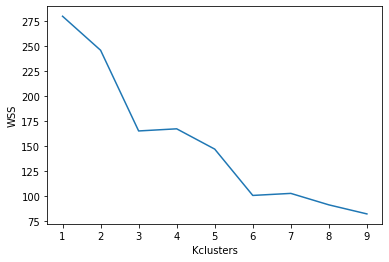

In [39]:
#Now we can plot the wss score per choosen number of clusters:
plt.plot(kclusters,elbow)
plt.xlabel("Kclusters")
plt.ylabel("WSS")

The choice of k here is slightly ambigious. One could go with k=3 or 6. Let's try the silhouette method to see if it makes it easier to decide:

In [26]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(to_array)
  labels = kmeans.labels_
  sil.append(silhouette_score(to_array, labels, metric = 'euclidean'))

Text(0, 0.5, 'Silhouette score')

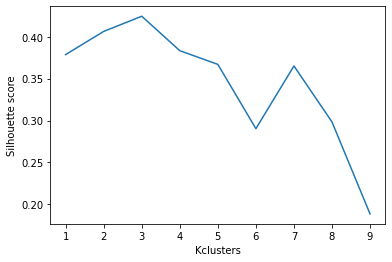

In [27]:
plt.plot(kclusters,sil)
plt.xlabel("Kclusters")
plt.ylabel("Silhouette score")

k=3 gives yields the highest score, so let's go for 3 clusters.

###Now we can run the k-means clustering and add a column containing respective cluster to the dataset

In [40]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(to_array)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

to_final.insert(11, 'Cluster Labels', kmeans.labels_)

to_final.head()

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate,French Restaurant,Restaurant Total freq,Score,Cluster Labels
0,Agincourt North,-3.9,3929,30414,4.293615,43.808038,-79.266439,-0.547813,0,10,-0.435626,1
1,Agincourt South-Malvern West,8.0,3034,31825,4.482889,43.781969,-79.257689,0.056557,0,13,-0.303647,1
2,Alderwood,1.3,2435,47709,7.383441,43.601717,-79.545232,-0.494522,0,1,-0.373271,1
3,Annex,4.6,10863,112766,19.737273,43.670338,-79.407117,0.625567,2,37,1.460323,0
4,Banbury-Don Mills,2.9,2775,67757,10.525366,43.752683,-79.365270,-0.451443,0,3,-0.146384,1


In [41]:
#Lets finally round the score to two decimals:
to_final["Score"]=to_final["Score"].round(2)

##*Results*

####Let's have a look at the characteristics of the top 10 scoring neighborhoods:

In [42]:
to_final.sort_values(by=['Score'], ascending=False).head(10)

,Neighborhood,Migration (%),Population per sqkm,Average income ($},French speaking (%),Latitude,Longitude,Normalized crime rate,French Restaurant,Restaurant Total freq,Score,Cluster Labels
71,Little Portugal,29.1,12859,45737,13.111382,43.647413,-79.431116,-0.277047,2,34,1.55,0
3,Annex,4.6,10863,112766,19.737273,43.670338,-79.407117,0.625567,2,37,1.46,0
87,Niagara,46.6,10156,70623,14.288005,43.644075,-79.408698,-0.023600,1,24,1.42,0
21,Casa Loma,4.6,5683,165047,19.556893,43.678102,-79.409416,-0.529586,2,17,1.38,2
23,Church-Yonge Corridor,10.6,23044,53583,15.236120,43.670786,-79.385687,2.202769,2,34,1.30,0
89,North St. James Town,4.4,44321,32648,9.481601,43.669403,-79.372704,0.277928,0,28,1.19,0
137,Yonge-St.Clair,7.5,10708,114174,18.518519,43.688078,-79.394396,-0.616629,1,16,1.07,0
116,The Beaches,2.1,6058,92580,16.900821,43.671024,-79.296712,-0.457048,2,14,0.95,0
16,Bridle Path-Sunnybrook-York Mills,6.3,1040,308010,19.102094,43.735900,-79.371900,-0.086733,0,1,0.92,2
122,Waterfront Communities-The Island,52.0,8943,70600,14.238466,43.772985,-79.499928,0.502178,0,8,0.88,0


Eight out of top-10 scoring neighborhoods belong to cluster 0

In [43]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, scores in zip(to_final['Latitude'], to_final['Longitude'], to_final['Neighborhood'], to_final['Cluster Labels'], to_final["Score"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + " Score " + str(scores), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Neighborhoods in cluster 0 and 2 are centrally located, compared to those in cluster 1

###What's the average score of the clusters?

<ErrorbarContainer object of 3 artists>

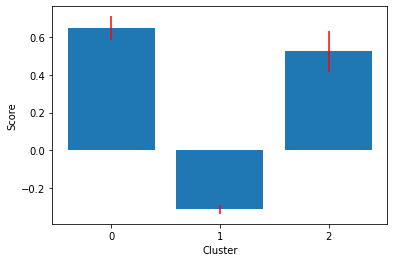

In [44]:
to_cluster_score = to_final.groupby("Cluster Labels")["Score"].mean()
to_cluster_sem = to_final.groupby("Cluster Labels")["Score"].sem()
Cluster=["0","1","2"]

plt.bar(Cluster, to_cluster_score)
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.errorbar(Cluster,to_cluster_score, yerr=to_cluster_sem, c="r", ls='none')

###Clusters 0 and 2 have the highest average scores. What are the differences between these?

Neighborhoods belonging to cluster 3 have a mean negative score and will not be regarded as suitable.

Ttest_indResult(statistic=2.364568799100784, pvalue=0.022424912266917306)


<ErrorbarContainer object of 3 artists>

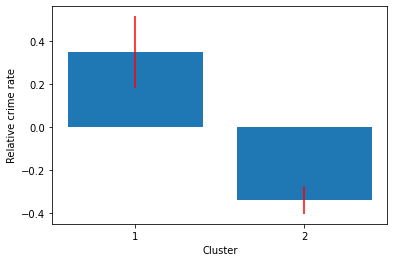

In [45]:
to_0vs2 = to_final.loc[to_final['Cluster Labels'].isin([0, 2])]
to_0vs2mean = to_0vs2.groupby(["Cluster Labels"]).mean()
to_0vs2sem = to_0vs2.groupby(["Cluster Labels"]).sem()

from scipy.stats import ttest_ind

cat1 = to_0vs2[to_0vs2['Cluster Labels'] == 0]
cat2 = to_0vs2[to_0vs2['Cluster Labels'] == 2]


x = ['1','2']

print(ttest_ind(cat1['Normalized crime rate'], cat2['Normalized crime rate']))

plt.bar(x, to_0vs2mean["Normalized crime rate"])
plt.xlabel("Cluster")
plt.ylabel("Relative crime rate")
plt.errorbar(x, to_0vs2mean["Normalized crime rate"], yerr=to_0vs2sem["Normalized crime rate"], c="r", ls='none')

Crime rate is significantly lower in cluster 2.

####Which are the 10 best/worst neighborhoods for a French restaurant?

/usr/local/lib/python3.7/dist-packages/pyforest/__init__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ._imports import *


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

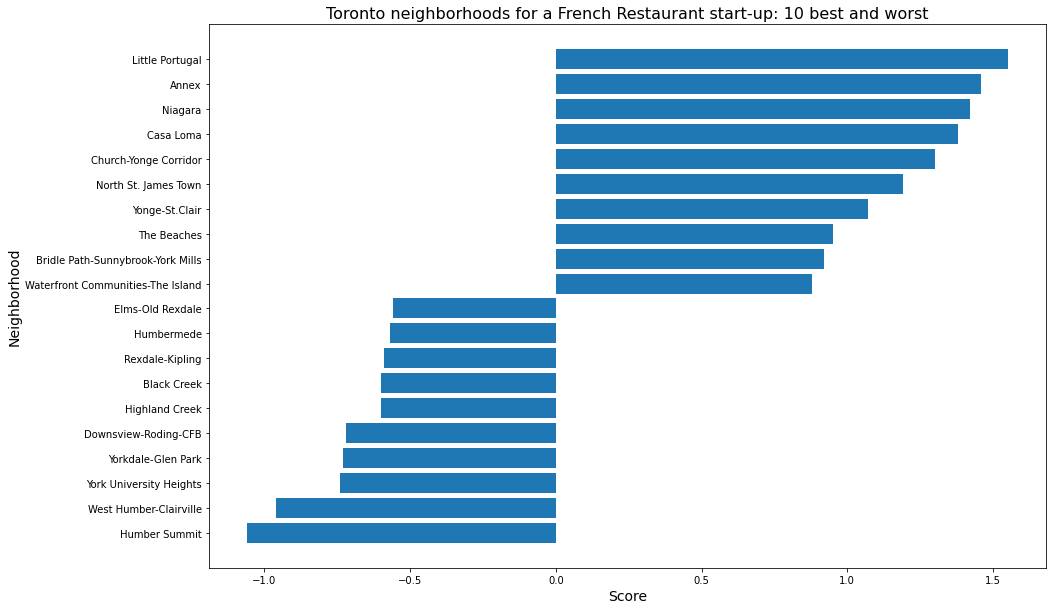

In [ ]:
to_french=to_final[["Neighborhood", "Score"]]
to_french.sort_values(by='Score', inplace=True)
to_top=to_french.head(10).tail(10)
to_bottom=to_french.tail(10)
to_french=pd.concat([to_top, to_bottom])
x=to_french["Neighborhood"]
y=to_french["Score"]

plt.figure(figsize=(15, 10))
plt.barh(x,y)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Toronto neighborhoods for a French Restaurant start-up: 10 best and worst", fontsize=16)
plt.show()
#plt.savefig('topbottom10.pdf')
#files.download('topbottom10.pdf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

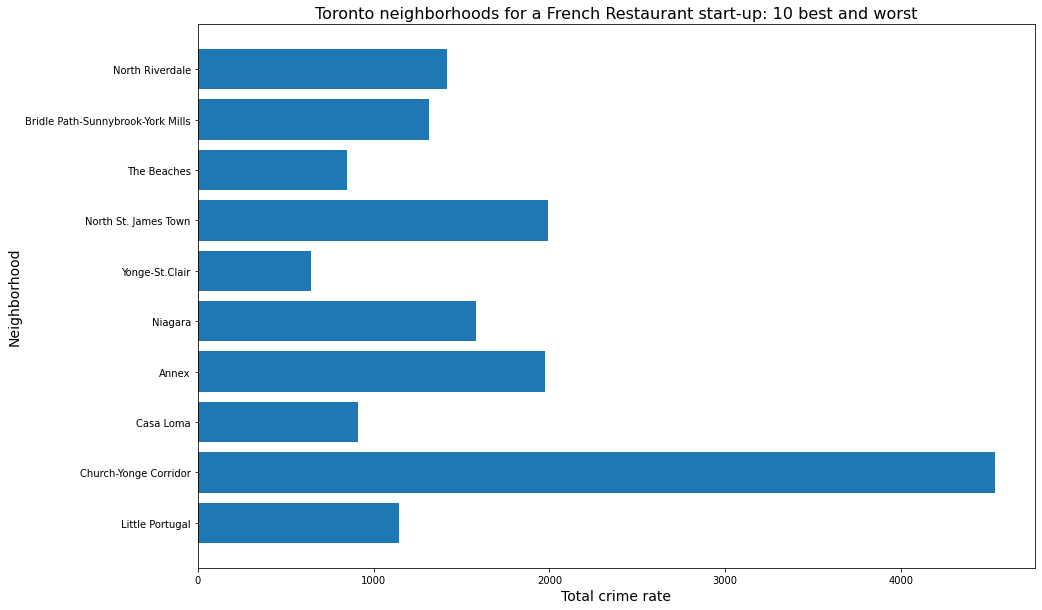

In [ ]:
to_french=to_final[["Neighborhood", "Score","Total crime rate"]]
to_french.sort_values(by='Score', ascending=False, inplace=True)
to_top=to_french.head(10)
x=to_top["Neighborhood"]
y=to_top["Total crime rate"]

plt.figure(figsize=(15, 10))
plt.barh(x,y)
plt.xlabel("Total crime rate", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Toronto neighborhoods for a French Restaurant start-up: 10 best and worst", fontsize=16)
plt.show()
#plt.savefig('topbottom10.pdf')
#files.download('topbottom10.pdf')

####The location of the 10 best neighborhoods can be visualized using Folium:

In [ ]:
to_top10=to_final.sort_values(by=['Score'], ascending=False).head(10)

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(to_top10['Latitude'], to_top10['Longitude'], to_top10['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

###Let's check our variables
####What does the distribution of French-speakers look like in Toronto?

In [ ]:
to_french=to_final[["Neighborhood", "French speaking (%)"]]
to_french.sort_values(by='French speaking (%)', ascending=False, inplace=True)

x=to_french["Neighborhood"]
y=to_french["French speaking (%)"]
plt.figure(figsize=(24, 6))
plt.bar(x,y)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("French speaking (%)", fontsize=12)
plt.title("French speakers in Toronto", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.show()

#plt.savefig('french.pdf')
#files.download('french.pdf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TypeError: ignored

####So French speaking percentage ranges from roughly 3 to 20 % in the neighborhoods. Is French speaking rate correlated with other variables in our dataset, like income? 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

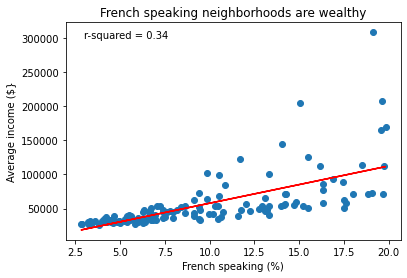

In [ ]:
R_square = r2_score(to_norm["French speaking (%)"], to_norm["Average income ($}"])

plt.scatter(to_final["French speaking (%)"], to_final["Average income ($}"])
plt.xlabel("French speaking (%)")
plt.ylabel("Average income ($}")
plt.title("French speaking neighborhoods are wealthy")
m, b = np.polyfit(to_final["French speaking (%)"], to_final["Average income ($}"], 1)
plt.plot(to_final["French speaking (%)"], m*to_final["French speaking (%)"]+b, c = "r")
#plt.annotate("r-squared = {:.2f}".format(r2_score(to_norm["French speaking (%)"], to_norm["Average income ($}"]), (3,300000)))
plt.annotate("r-squared = {:.2f}".format(R_square), (3,300000))
#plt.show()
plt.savefig('wealth.pdf')
files.download('wealth.pdf')

There is a correlation between French speaking neighborhoods and income, although the r2-score is not very high. Simple linear regression is probably not optimal here, I  leave it to the reader to explore it further if interested.

####How about crime rate?

/usr/local/lib/python3.7/dist-packages/pyforest/__init__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ._imports import *


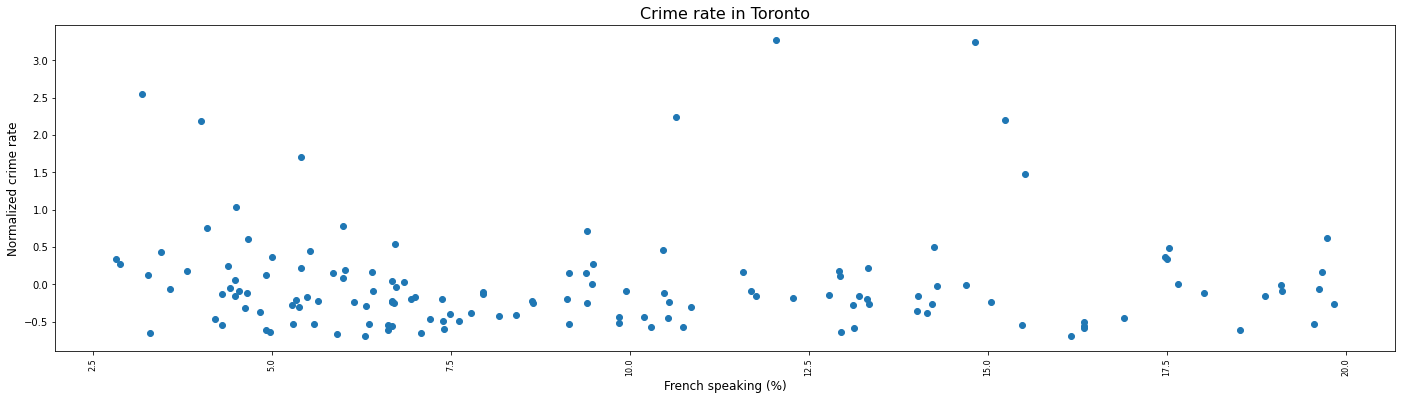

In [47]:
to_french=to_final[["French speaking (%)", "Normalized crime rate"]]
to_french.sort_values(by='Normalized crime rate', inplace=True)

x=to_french["French speaking (%)"]
y=to_french["Normalized crime rate"]

plt.figure(figsize=(24, 6))
plt.scatter(x,y)
plt.xlabel("French speaking (%)", fontsize=12)
plt.ylabel("Normalized crime rate", fontsize=12)
plt.title("Crime rate in Toronto", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.show()
#plt.savefig('crime.pdf')
#files.download('crime.pdf')

Four neighborhoods have a clearly higher crime rate than the rest.

####Let's finally have a look at which variables are most influential for the score

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

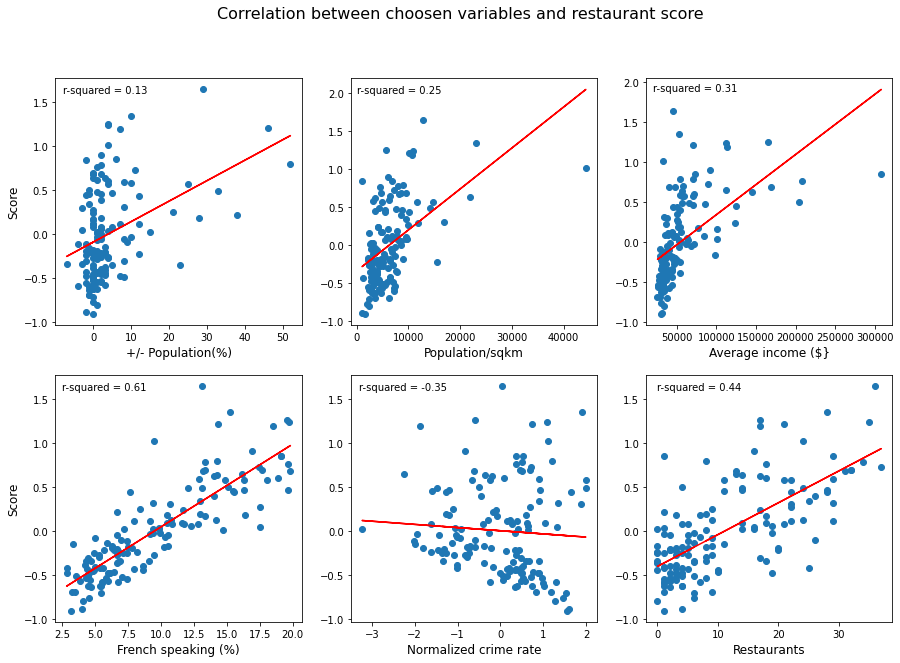

In [ ]:
to_norm["Normalized crime rate"]=to_norm["Crime rate inv"]*-1
y = to_final["Score"]
#Calculating R2-scores
R1 = r2_score(to_norm["+/- Population(%)"], y)
R2 = r2_score(to_norm["Population/sqkm"], y)
R3 = r2_score(to_norm["Average income ($}"], y)
R4 = r2_score(to_norm["French speaking (%)"], y)
R5 = r2_score(to_norm["Normalized crime rate"], y)
R6 = r2_score(to_norm["Restaurant Total freq"], y)

#Subplotting
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)

ax.scatter(to_final["+/- Population(%)"],y)
ax.set_xlabel("+/- Population(%)", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
m, b = np.polyfit(to_final["+/- Population(%)"], y, 1)
ax.plot(to_final["+/- Population(%)"], m*to_final["+/- Population(%)"]+b, c = "r")
ax.annotate("r-squared = {:.2f}".format(R1), (-8,1.6))

ax2.scatter(to_final["Population/sqkm"],y)
ax2.set_xlabel("Population/sqkm", fontsize=12)
m, b = np.polyfit(to_final["Population/sqkm"], y, 1)
ax2.plot(to_final["Population/sqkm"], m*to_final["Population/sqkm"]+b, c = "r")
ax2.annotate("r-squared = {:.2f}".format(R2), (0,2))

ax3.scatter(to_final["Average income ($}"],y)
ax3.set_xlabel("Average income ($}", fontsize=12)
m, b = np.polyfit(to_final["Average income ($}"], y, 1)
ax3.plot(to_final["Average income ($}"], m*to_final["Average income ($}"]+b, c = "r")
ax3.annotate("r-squared = {:.2f}".format(R3), (20000,1.89))

ax4.scatter(to_final["French speaking (%)"],y)
ax4.set_xlabel("French speaking (%)", fontsize=12)
ax4.set_ylabel("Score", fontsize=12)
m, b = np.polyfit(to_final["French speaking (%)"], y, 1)
ax4.plot(to_final["French speaking (%)"], m*to_final["French speaking (%)"]+b, c = "r")
ax4.annotate("r-squared = {:.2f}".format(R4), (2.5,1.6))

ax5.scatter(to_norm["Normalized crime rate"],y)
ax5.set_xlabel("Normalized crime rate", fontsize=12)
m, b = np.polyfit(to_norm["Normalized crime rate"], y, 1)
ax5.plot(to_norm["Normalized crime rate"], m*to_norm["Normalized crime rate"]+b, c = "r")
ax5.annotate("r-squared = {:.2f}".format(R5), (-3.3,1.6))

ax6.scatter(to_final["Restaurant Total freq"],y)
ax6.set_xlabel("Restaurants", fontsize=12)
m, b = np.polyfit(to_final["Restaurant Total freq"], y, 1)
ax6.plot(to_final["Restaurant Total freq"], m*to_final["Restaurant Total freq"]+b, c = "r")
ax6.annotate("r-squared = {:.2f}".format(R6), (0,1.6))

f.suptitle('Correlation between choosen variables and restaurant score', fontsize=16)
plt.savefig('all.pdf')
files.download('all.pdf')

This is just a quick test with simple linear regression, some would likely fit better with e.g. polynomial regression. The main take-home message is that neighborhoods with a high proportion of French speakers are excellent candidates for setting up the restaurant. Crime rates are not correlated with the restaurant scoring, but is nevertheless of importance for many who wishes to open a venue and should therefore be taken into account in the final decision.

####Finally, let's check the contribution of the no. of French Restaurants/neighborhood to the score. Note, that since there are so few restaurants here, it makes more sense with a barplot:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

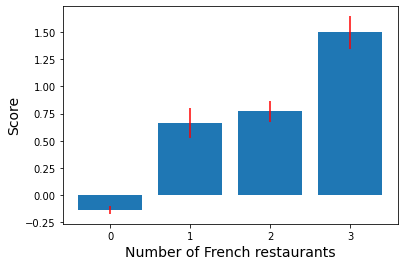

In [ ]:
a = to_final.groupby(to_final['French Restaurant']).sem()
b = to_final.groupby(to_final['French Restaurant']).mean()
b.reset_index(inplace=True)
b["French Restaurant"]=b["French Restaurant"].astype(str)

plt.bar(b["French Restaurant"], b["Score"])
plt.xlabel("Number of French restaurants", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.errorbar(b["French Restaurant"],b["Score"], yerr=a["Score"], c="r", ls='none')
plt.savefig('rest.png')
files.download('rest.png')

The number of French restaurants in a neighborhood is also likely important, but since there are quite few of them it is hard to draw definitive conclusions. In general, nearby restaurants can both raise attractivness of the neighborhood for costumers as well as increases competition, especially if they are in the same category. 

##*Discussion*
Little Portugal is the top scorer for a French restaurant start-up. One has to bear in mind, however, that there are already three French restaurant along with several other restaurants in the neighborhood, which makes it more competitive. Conversely, if one is looking for a neighborhood devoid of a French restaurant (least competitive), two placeed in the top 10 list: North St. James Town and Bridle Path-Sunnybrook-York Mills. These are quite dissimilar, North St. James Town (cluster 0) is densely populated, with relatively low average income and above average crime rate; Bridle Path-Sunnybrook-York Mills (cluster 2) has a very high average income and below-average crime rate but is relatively sparsely populated and have only one restaurant. For a highly ambitious restaurant I would in this case recommend Bridle Path-Sunnybrook-York Mills, e.g. according to [Guide Michelin's grading definition](https://guide.michelin.com/th/en/to-the-stars-and-beyond-th), stars are provided based on whether the visit is worth a stay, detour or special journey. Therefore a less dense neighborhood is not a problem if people are willing to travel (although the restaurant might risk running a cold start). 

##*Conclusion*
To conclude, this analysis has provided putative neighborhoods for a French cusine start-up and can serve as basis for customers to further explore top scoring areas for a good spot to open their business.  